## Generative Latent Replay

Experimental code to test generative latent replay on benchmark continual learning problems.

i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [4]:
# ML imports
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import transforms as T
from avalanche.benchmarks.classic import RotatedMNIST, PermutedMNIST

# Local imports
from src import utils, plotting, models

# Continual Learning strategies
from avalanche.training import Naive, Replay, plugins
from src.strategies import LatentReplay, GenerativeLatentReplay

Setup

In [5]:
# Reproducibility
SEED = 731
utils.set_seed(SEED)

# Reporting
eval_rate = 1

Problem definition

In [6]:
# Dataset
n_experiences = 3
transform = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])

experiences = PermutedMNIST(
        n_experiences=n_experiences,
        train_transform=transform,
        eval_transform=transform,
        seed=SEED,
        #rotations_list=[0, 60, 300],
    )

train_stream = experiences.train_stream
test_stream = experiences.test_stream

Hyperparameters

In [7]:
# Replays
replay_buffer_size = 6000

# Frozen backbone
freeze_depth = 1
latent_layer_number = freeze_depth * 3

# SGD hyperparams
sgd_kwargs = {
    "lr": 0.1,  # 0.001
    "momentum": 0.9,
    "weight_decay": 0.0005, #l2 regularization
}

strategy_kwargs = {
    "eval_every": eval_rate,
    "train_epochs": 40,
    "train_mb_size": 128,
    "eval_mb_size": 512,
    "device": utils.get_device(),
    "plugins": [
        plugins.EarlyStoppingPlugin(
            patience=eval_rate,
            val_stream_name="train_stream/Task000",
            margin=0.005,  # metric
        )
    ],
}


Building base model

In [8]:
# Model
model_glr = models.SimpleMLP()
model_naive = models.SimpleMLP()
model_replay = models.SimpleMLP()

c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loading Continual Learning strategies for experiments

Training loop

In [9]:
# Loading GLR model
strategy_glr = GenerativeLatentReplay(
    model=model_glr,
    rm_sz=replay_buffer_size,
    latent_layer_num=latent_layer_number,
    evaluator=utils.get_eval_plugin("generative_latent_replay"),
    **strategy_kwargs,
    **sgd_kwargs,
)

# eval_streams=[train_exp] to get validation on current experience (minus replays?)
for train_exp in train_stream:
    strategy_glr.train(train_exp) #, eval_streams=[train_exp])
    strategy_glr.eval(train_stream)

utils.close_loggers(strategy_glr)

c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 0...
Generator trained.


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 1...
Generator trained.


c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


Training generator 2...
Generator trained.


In [ ]:
# Loading baseline (naive) model
strategy_naive = Naive(
    model=model_naive,
    optimizer=SGD(model_naive.parameters(), **sgd_kwargs),
    evaluator=utils.get_eval_plugin("naive"),
    **strategy_kwargs,
)

for train_exp in train_stream:
    strategy_naive.train(train_exp, eval_streams=[train_exp])
    strategy_naive.eval(train_stream)

utils.close_loggers(strategy_naive)

In [ ]:
# Loading benchmark (replay) model
strategy_replay = Replay(
    model=model_replay,
    criterion=CrossEntropyLoss(),
    optimizer=SGD(model_replay.parameters(), **sgd_kwargs),
    replay_buffer_size=replay_buffer_size,
    evaluator=utils.get_eval_plugin("replay"),
    **strategy_kwargs,
)

for train_exp in train_stream:
    strategy_replay.train(train_exp, eval_streams=[train_exp])
    strategy_replay.eval(train_stream)

utils.close_loggers(strategy_replay)

Plotting

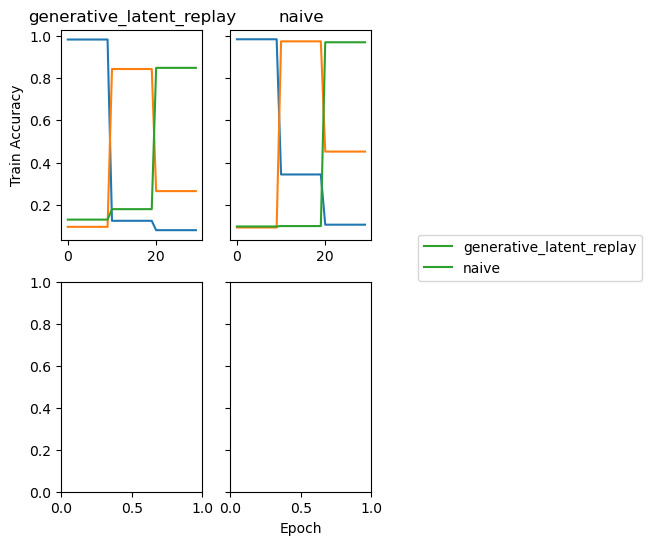

In [10]:
import importlib; importlib.reload(plotting)
plotting.plot_multiple_results()

In [ ]:
plotting.results_to_df(results)